In [2]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Kaiming Init!
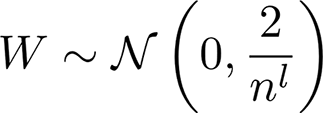

# API Setup

In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from pathlib import Path
from IPython.core.debugger import set_trace #?? what is set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import torch.nn.functional as F
from torch import nn
from functools import partial
import math
mpl.rcParams['image.cmap'] = 'gray' # otherwise colours seem different. Black ->purple
from IPython.core.debugger import set_trace

import re
from torch.nn import init


def get_data(url):
    with gzip.open(path, mode='rb') as f:
        ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding='latin-1')
    return map(tensor,(x_train,y_train,x_valid,y_valid))

MNIST_url="http://deeplearning.net/data/mnist/mnist.pkl"
path=datasets.download_data(MNIST_url,ext='.gz'); path

def normalize(x,mean=None,std=None):
    m=mean if mean else x.mean()
    s=std if std else x.std()
    return (x-m)/s

def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train,m,s), normalize(valid,m,s)

In [28]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y=x,y
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, i): return self.x[i], self.y[i]

def collate(b):
    x,y=zip(*b)
    return torch.stack(x), torch.stack(y)

def get_dls(train_ds, valid_ds, bs=1, **kwargs):
    train_dl=DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate, **kwargs)
    valid_dl=DataLoader(valid_ds, batch_size=2*bs, shuffle=False, collate_fn=collate,**kwargs)
    return train_dl,valid_dl

class Databunch():
  def __init__(self, train_dl, valid_dl, c=None):
    self.train_dl, self.valid_dl, self.c= train_dl, valid_dl, c
  @property
  def train_ds(self): return self.train_dl.dataset
  @property
  def valid_ds(self): return self.valid_dl.dataset

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data =model,opt,loss_func, data

x_train, y_train, x_valid, y_valid= get_data(MNIST_url)
x_train,x_valid = normalize_to(x_train,x_valid)

train_ds, valid_ds= Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy
data = Databunch(*get_dls(train_ds, valid_ds, bs), c)

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
  s1 = re.sub(_camel_re1, r'\1_\2', name)
  return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    def set_runner(self,run): self.run = run
    def __getattr__(self,k): return getattr(self.run,k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    def __call__(self, cb_name):
        cb=getattr(self,cb_name,None)
        if cb and cb(): return True
        return False

class TrainEvalCallback(Callback):
    _order=0
    def begin_fit(self):
        self.run.n_iters=0
        self.run.n_epochs=0
    def after_batch(self):
        if not self.in_train:return
        self.run.n_iters+=1
        self.run.n_epochs+=1./self.iters
    def begin_epoch(self):
        self.run.in_train=True
        self.model.train()
        # print(f"Epoch: {self.run.epoch}")
    def begin_validate(self):
        self.run.in_train=False
        self.model.eval()

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

class TestCallback(Callback):
    _order=1
    def after_batch(self):
        if self.n_iters>=10: 
            print(f"Iteration 10: Exiting now!")
            raise CancelTrainException()

from typing import *

def listify(item):
    if item is None: return []
    if isinstance(item,List):return item
    if isinstance(item, str): return [item]
    if isinstance(item,Iterable): return list(item)
    return [item]

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs=listify(cbs)
        for cbf in listify(cb_funcs):
            cb=cbf()
            setattr(self,cb.name, cb)
            cbs.append(cb)
        #self.stop=False
        self.cbs=[TrainEvalCallback()]+cbs
  
    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self): return self.learn.data

#Now you dont have to do "if self(callback): return" everytime! Because control is done through an Exception. Simply do self(callback) 
    def one_batch(self,xb,yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self,dl):
        self.iters=len(dl)
        try:
          for xb,yb in dl: self.one_batch(xb,yb)
        except CancelEpochException: self('after_cancel_batch')
  
    def fit(self,epochs,learn):
        self.epochs,self.learn = epochs,learn
        #self.loss=tensor(0.)
        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(self.epochs):
                self.epoch=epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                    self('after_epoch')
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn=None

    def __call__(self,cb_name):
        res=False
        for cb in sorted(self.cbs,key=lambda x: x._order): res = cb(cb_name) or res
        return res 

def get_runner(model,data,lr=0.5,cbs=None,opt_func=None,loss_func=F.cross_entropy):
    #returns learn, runner
    opt_func=opt_func if opt_func else torch.optim.SGD
    learn=Learner(model,opt_func(model.parameters(),lr=lr),loss_func,data)
    run=Runner(cb_funcs=listify(cbs))
    return learn, run

class AvgStats():
    def __init__(self,metrics,in_train):
        self.metrics,self.in_train=listify(metrics),in_train
    def reset(self):
        self.total_loss=0.
        self.count=0
        self.all_metrics=[0.] * len(self.metrics)

    @property
    def total_stats(self): return [self.total_loss.item()]+self.all_metrics
    @property
    def avg_stats(self): return [o/self.count for o in self.total_stats]

    def accumulate(self,run):
        bn=run.xb.shape[0]
        self.total_loss+=run.loss*bn
        self.count+=bn
        for i,m in enumerate(self.metrics): self.all_metrics[i]+=m(run.pred,run.yb)*bn
    def __repr__(self):
        if not self.count: return ""
        # return f"{'training' if self.in_train else 'validation'}:{self.avg_stats}"

class AvgStatsCallback(Callback):
    _order=2
    def __init__(self,metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,in_train=True),AvgStats(metrics,in_train=False)
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    def after_loss(self):
        stats=self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    def after_epoch(self): pass
        # print(self.train_stats)
        # print(self.valid_stats)

class Recorder(Callback):
    _order=3
    def begin_fit(self):
        self.losses = []
        self.lrs = [[] for _ in self.opt.param_groups]

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr(self,pg=-1): 
        plt.ylabel("learning rate")
        plt.xlabel("batches")
        plt.plot(self.lrs[pg])

    def plot_losses(self, skip_last=0):
        plt.ylabel("loss")
        plt.xlabel("batches")
        plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pg=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pg]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.xlabel("learning rate")
        plt.ylabel("loss")
        plt.plot(lrs[:n],losses[:n])

#__________________________________________________________________________________________________________________________
#CNN
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
    def forward(self,x): return self.func(x)
    def __repr__(self): return f"Lambda({str(self.func).split()[1]})"

def flatten(x): return x.view(x.shape[0],-1)

def mnist_resize(x): return x.view(-1,1,28,28)

def get_cnn_model(data):
    assert data.c is not None, f"data.c is not defined in the DataLoader initialization"
    return nn.Sequential(Lambda(mnist_resize),
                         nn.Conv2d(1,8,5, stride=2,padding=2), nn.ReLU(), #padding=kernel_size//2   #size=14
                         nn.Conv2d(8,16,3,2,padding=1),nn.ReLU(),#7
                         nn.Conv2d(16,32,3,2,padding=1),nn.ReLU(),#4
                         nn.Conv2d(32,32,3,2,padding=1),nn.ReLU(),#2
                         nn.AdaptiveAvgPool2d(1), #why??? average pool across all pixels is a shit idea no?
                         Lambda(flatten),
                         nn.Linear(32,data.c)
                         )
    
device=torch.device('cuda',0)
torch.cuda.set_device(device)
class CudaCallback(Callback):
    _order=0
    # def __init__(self,device): self.device=device
    def begin_fit(self): 
        # self.model.to(device)
        self.model.cuda()

    def begin_batch(self):
        # self.run.xb,self.run.yb = self.xb.to(device),self.yb.to(device)
        self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

def conv2d(ni,nf,kernel_size=3,stride=2):
    return nn.Sequential(nn.Conv2d(ni,nf,kernel_size,stride,padding=kernel_size//2),nn.ReLU())
class BatchtfmXCallback(Callback):
    _order=1
    def __init__(self,tfm): self.tfm=tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner 


In [3]:
% cd  '/content/drive/My Drive/AI Stuff/projects/DMGNN ML Course'

/content/drive/My Drive/AI Stuff/projects/DMGNN ML Course


In [4]:
# !git clone https://github.com/garroud/human-motion-prediction-pytorch.git
# %cd human-motion-prediction-pytorch
# !mkdir data
# %cd data
# !wget http://www.cs.stanford.edu/people/ashesh/h3.6m.zip
# !unzip h3.6m.zip
# !rm h3.6m.zip
# %cd ..
#____________________________________________________________________________________________________________________________________________

# !git clone https://github.com/facebookresearch/QuaterNet
%cd QuaterNet

/content/drive/My Drive/AI Stuff/projects/DMGNN ML Course/QuaterNet


# WITH NORMAL INITIALIZATION

In [6]:
!python prepare_data_long_term.py


Extracting locomotion dataset...
Converting format...
Done.


In [ ]:
!pip install numpy==1.16.1
import numpy as np

In [6]:
!python train_long_term.py

# parameters: 9529246
112 sequences were discarded for being too short.
Training on 264 sequences, validating on 0 sequences.
Training for 4000 epochs
[1] loss: 12.04287 lr 0.001000 tf_ratio 1.000000
[2] loss: 5.51746 lr 0.000999 tf_ratio 0.995000
[3] loss: 4.52594 lr 0.000998 tf_ratio 0.990025
[4] loss: 4.04412 lr 0.000997 tf_ratio 0.985075
[5] loss: 4.19253 lr 0.000996 tf_ratio 0.980150
[6] loss: 3.81433 lr 0.000995 tf_ratio 0.975249
[7] loss: 3.71688 lr 0.000994 tf_ratio 0.970373
[8] loss: 3.65611 lr 0.000993 tf_ratio 0.965521
[9] loss: 3.42756 lr 0.000992 tf_ratio 0.960693
[10] loss: 3.14321 lr 0.000991 tf_ratio 0.955890
Benchmark: 1.1207648913065593 s per epoch
[11] loss: 2.92782 lr 0.000990 tf_ratio 0.951110
[12] loss: 2.72884 lr 0.000989 tf_ratio 0.946355
[13] loss: 2.53648 lr 0.000988 tf_ratio 0.941623
[14] loss: 2.49590 lr 0.000987 tf_ratio 0.936915
[15] loss: 2.39507 lr 0.000986 tf_ratio 0.932230
[16] loss: 2.13444 lr 0.000985 tf_ratio 0.927569
[17] loss: 2.11619 lr 0.000984 

In [29]:
def get_cnn_layers(data,nfs):
    nfs = [1]+nfs
    return [
            conv2d(nfs[i],nfs[i+1],kernel_size=5 if i==0 else 3) for i in range(len(nfs)-1)
            ]+[nn.AdaptiveAvgPool2d(1),Lambda(flatten),nn.Linear(nfs[-1],data.c)]         

def get_cnn_model(data,nfs): return nn.Sequential(*get_cnn_layers(data,nfs))    

mnist_view = view_tfm(1,28,28)
nfs=[8,16,32,32]
cb_funcs=[Recorder,
          partial(AvgStatsCallback,accuracy),
          CudaCallback,
          partial(BatchtfmXCallback,mnist_view)
          ]

class SequentialModel(nn.Module):
    def __init__(self,*layers):
        super().__init__()
        self.layers=nn.ModuleList(layers) # MODULELIST is amazing! registers layers as a module child of the model(though as a single module, not individulaly)
        self.act_means=[[] for _ in self.layers]
        self.act_stds=[[] for _ in self.layers]
    def __call__(self,xb):
        for i,layer in enumerate(self.layers):
            xb=layer(xb)
            self.act_means[i].append(xb.mean())
            self.act_stds[i].append(xb.std())
        return xb
    def __iter__(self): return iter(self.layers) 

model=SequentialModel(*get_cnn_layers(data,nfs))
learn,run = get_runner(model,data,lr=0.9,cbs=cb_funcs)
run.fit(2,learn)

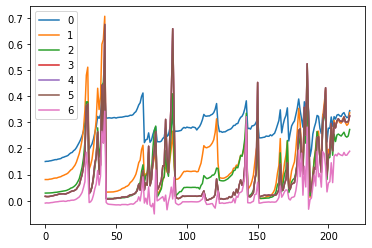

In [30]:
for i in model.act_means: plt.plot(i)
plt.legend(range(len(model.layers)))

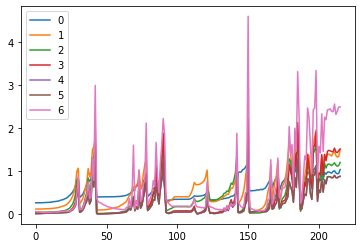

In [31]:
for i in model.act_stds: plt.plot(i)
plt.legend(range(len(model.layers)))

# WITH KAIMING INITIALIZATION

In [5]:
!python train_pace_network.py #RUN FIRST
# !python train_long_term.py

112 sequences were discarded for being too short.
Training on 112 sequences, validating on 0 sequences.
[1] loss 0.622317
[2] loss 0.579163
[3] loss 0.560915
[4] loss 0.518638
[5] loss 0.502019
[6] loss 0.470994
[7] loss 0.448389
[8] loss 0.411811
[9] loss 0.396011
Benchmark: 0.20290260844760472 s per epoch
[10] loss 0.359388
[11] loss 0.328194
[12] loss 0.285529
[13] loss 0.248454
[14] loss 0.222768
[15] loss 0.184625
[16] loss 0.179538
[17] loss 0.182407
[18] loss 0.173665
[19] loss 0.157948
Benchmark: 0.1999427556991577 s per epoch
[20] loss 0.161609
[21] loss 0.157423
[22] loss 0.158427
[23] loss 0.158241
[24] loss 0.153431
[25] loss 0.154137
[26] loss 0.148768
[27] loss 0.155112
[28] loss 0.150989
[29] loss 0.146865
Benchmark: 0.20018484592437744 s per epoch
[30] loss 0.158159
[31] loss 0.151760
[32] loss 0.147417
[33] loss 0.150840
[34] loss 0.147813
[35] loss 0.142831
[36] loss 0.149511
[37] loss 0.139226
[38] loss 0.149600
[39] loss 0.142608
Benchmark: 0.2042694330215454 s per 

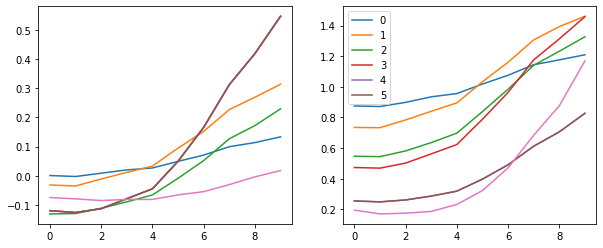

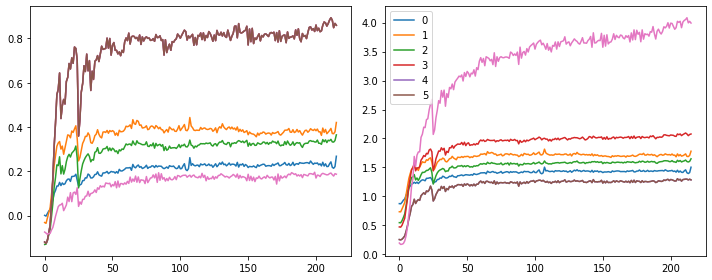

In [32]:
def children(m): return list(m.children()) # equivalent to [layer for layer in model] or simply list(model) (since nn.Sequential has a __iter__ method)

class Hook():
    def __init__(self, module, func): self.hook = module.register_forward_hook(partial(func, self)) 
    # what does register_forward_hook return ? A (removable) handle that can be used to remove the added hook by calling handle.remove()
    def remove(self): self.hook.remove()
    def __del__(self): self.remove() # called when jupyter does some automatic cleaning.

def append_stats(hook, mod, inp, out):
    if not hasattr(hook,'stats'): hook.stats =([],[])
    mean,std=hook.stats
    mean.append(out.mean())
    std.append(out.std())

class ListContainer(): #a class that has the properties of a list
    def __init__(self,items): self.items=listify(items)
    def __getitem__(self,idx):
        if isinstance(idx,(int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self.items), f"length of indices must be in congruence with the number of items"
            #return [self.items[o] for o in i if o] this doesnt work because self.items[o] is part of __getitem__ which is not defined 
            return [m for o,m in zip(idx,self.items) if o]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self,i,val): self.items[i]=val
    def __delitem__(self,i): self.items[i].remove()
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self[:10]}'
        if len(self)>10: res=res[:-1]+'...]'
        return res

class Hooks(ListContainer):
    def __init__(self,mods,f): self.hooks = super().__init__([Hook(mod,f) for mod in mods])    #mod -> module
    def __enter__(self, *args):return self # for generalization. Just in case some exception occurs
    def __exit__(self, *args): self.remove() # not required in enter, but exit takes 4 arguments(self, exc_type, exc_value, traceback), which we don't want to handle
    def __del__(self):self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i) # lol , the code works just fine without this statement, MUST ONLY BE A MEMORY ISSUE!s
    def remove(self): 
        for h in self: h.remove()

def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs=[1]+nfs
    return [layer(nfs[i],nfs[i+1],5 if i==0 else 3, **kwargs) for i in range(len(nfs)-1)
            ]+ [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return  nn.Sequential(nn.Conv2d(ni,nf,ks, stride=stride, padding=ks//2),GeneralizedRelu(**kwargs))
class GeneralizedRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv
    def forward(self,x):
        x=F.leaky_relu(x,self.leak if self.leak else 0.)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def kaiming_init_cnn(model, uniform=False):
    f=init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in model:
        if isinstance(l,nn.Sequential):
            f(l[0].weight)
            l[0].bias.data.zero_()

def get_cnn_model(data,nfs,layer, **kwargs):
    model=nn.Sequential(*get_cnn_layers(data,nfs,layer,**kwargs))
    return model

def append_stats(hook,mod,inp,out):
    if not hasattr(hook,'stats'): hook.stats=([],[],[])
    m,s,hist=hook.stats
    m.append(out.mean())
    s.append(out.std())
    hist.append(out.data.cpu().histc(40,-7,7))

model=get_cnn_model(data,nfs,conv_layer,leak=0.1,sub=0.4,maxv=6.)
kaiming_init_cnn(model,uniform=True)
learn,run=get_runner(model,data,cbs=cb_funcs)

with Hooks(model,append_stats) as hooks:
    run.fit(2,learn)
    _,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss,_=h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6))
    _,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss,_=h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        h.remove()
    plt.legend(range(6))

    # _,axes = plt.subplots(2,2,figsize=(15,6))
    # for ax,h in zip(axes.flatten(), hooks[:4]): #without flatten(), it gives nnumpy.darray has no attribute imshow
    #     # ax.imshow(get_hist(h), origin='lower')
    #     ax.axis('off')
    plt.tight_layout()